In [13]:
import json
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette('colorblind')

Replicating Wilcox et al's basic results before island constraints.

In [14]:
all_outputs = os.listdir("grammar_outputs/wilcox_replication")
basic_outputs = [output_file for output_file in all_outputs if "basic" in output_file]
basic_effects = []
for output_filename in basic_outputs:
    construction_data = json.load(open(os.path.join("grammar_outputs", "wilcox_replication", output_filename)))
    stim_id = 1
    # get model/construction (subj obj or pp) from filenames
    model_name = output_filename.split(".json")[0][-4:]
    construction_name = output_filename.split(".json")[0].split("_")[1]
    for stim_set in construction_data:
        basic_effects.append({
            "item": stim_id,
            "model": model_name,
            "test": construction_name,
            "gap": "gap",
            "wh_effect": stim_set['s_ab']['critical_surprisal'] - stim_set['s_xb']['critical_surprisal']
        })
        basic_effects.append({
                        "item": stim_id,
            "model": model_name,
            "test": construction_name,
            "gap": "nogap",
            "wh_effect": stim_set['s_ax']['critical_surprisal'] - stim_set['s_xx']['critical_surprisal']
        })
        stim_id +=1


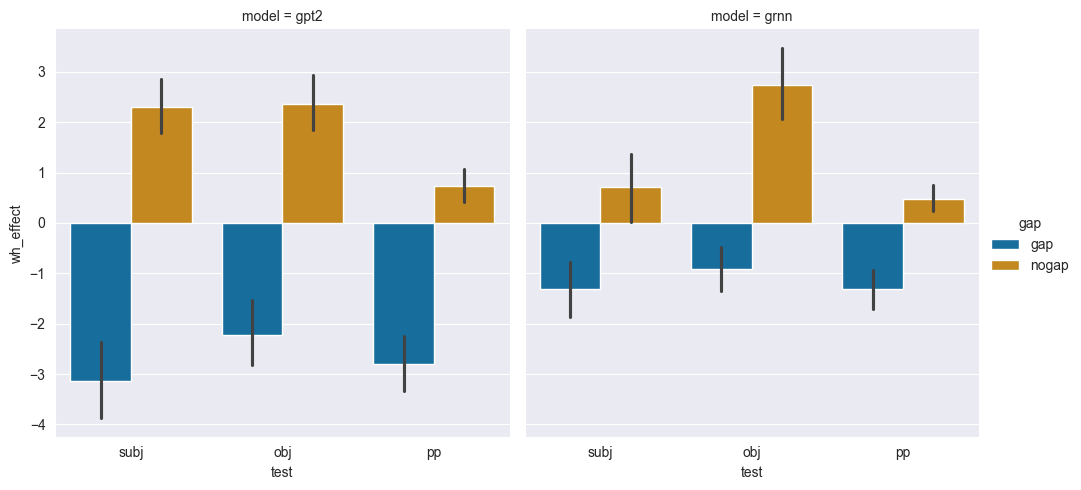

In [15]:
basic_effects = pd.DataFrame(basic_effects)
sns.catplot(x="test", y="wh_effect", hue="gap", data=basic_effects, kind="bar", col = "model",
            estimator="mean")
if "figures" not in os.listdir("."):
    os.mkdir("figures")
plt.savefig("figures/basic_fg.png")

Wilcox et al: run "Linear mixed-effects models on raw surprisal values with sum-coded conditions and by-item random slopes". We're looking for a significantly negative interaction term between the presence & absence of gaps.

In order to do this, we need to re-read the files for raw surprisal values and make features to put into our regression model (wh/that, gap/nogap)

In [16]:
def modify_base_dict(sentence_key, stim_set, base_dict):
    sent_copy = base_dict.copy()
    # replace 0 with -1 for island
    if sentence_key == "s_ab":
        sent_copy['wh'] = 1
        sent_copy['gap'] = 1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    elif sentence_key == "s_xb":
        sent_copy['wh'] = 0
        sent_copy['gap'] = 1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    elif sentence_key == "s_ax":
        sent_copy['wh'] = 1
        sent_copy['gap'] = 0
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    else: # s_xx
        sent_copy['wh'] = 0
        sent_copy['gap'] = 0
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    return sent_copy

In [17]:
basic_surprisals = []
for output_filename in basic_outputs:
    construction_data = json.load(open(os.path.join("grammar_outputs", "wilcox_replication",output_filename)))
    stim_id = 1
    # adding surprisals individually because that's what works with the sentence tuples
    for i in construction_data:
        model_name = output_filename.split(".json")[0][-4:]
        construction_name = output_filename.split(".json")[0].split("_")[1]
        for stim_set in construction_data:
            base_info = {
                "item": stim_id,
                "model": model_name,
                "test": construction_name
            }
            basic_surprisals.append(modify_base_dict("s_ab", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_xb", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_ax", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_xx", stim_set, base_info))
            stim_id +=1

In [18]:
basic_surprisals = pd.DataFrame(basic_surprisals)

We now fit mixed-effects models for each model & condition

In [19]:
from pymer4.models import Lmer

In [20]:
def fit_regression_model(lm, condition, surprisal_data, formula):
    condition_data = surprisal_data[(surprisal_data['model'] == lm) & (surprisal_data['test'] == condition)]
    model = Lmer(formula, data = condition_data)
    model.fit()
    return model.summary()

In [21]:
import itertools

In [22]:
conditions, models = basic_surprisals['test'].unique(), basic_surprisals['model'].unique()
interaction_results = []
basic_formula = "surprisal ~ wh * gap + (wh+gap || item)"
for condition, model in itertools.product(conditions, models):
    print(condition , model)
    summary = fit_regression_model(model, condition, basic_surprisals, basic_formula)
    result = summary[['Estimate', 'P-val', 'Sig']].iloc[-1]
    result['model'] = model
    result['condition'] = condition
    interaction_results.append(result)


subj gpt2
boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 10000	 Groups: {'item': 2500.0}

Log-likelihood: -27058.762 	 AIC: 54133.524

Random effects:

                 Name     Var    Std
item      (Intercept)  18.778  4.333
item.1             wh   0.000  0.000
item.2            gap  37.460  6.120
Residual                3.001  1.732

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 10000	 Groups: {'item': 2500.0}

Log-likelihood: -27058.762 	 AIC: 54133.524

Random effects:

                 Name     Var    Std
item      (Intercept)  18.778  4.333
item.1             wh   0.000  0.000
item.2            gap  37.460  6.120
Residual                3.001  1.732

No random effect corr

We have a negative interaction term, and the result is statistically significant (really low p-values get rounded down to 0).

In [23]:
pd.DataFrame(interaction_results)

,Estimate,P-val,Sig,model,condition
wh:gap,-5.449,0.0,***,gpt2,subj
wh:gap,-2.036,0.0,***,grnn,subj
wh:gap,-4.579,0.0,***,gpt2,obj
wh:gap,-3.656,0.0,***,grnn,obj
wh:gap,-3.542,0.0,***,gpt2,pp
wh:gap,-1.790,0.0,***,grnn,pp


## Plotting the Island data

In [24]:
from generate_corpora import corpus_from_json
from analysis import island_effects_for_model
import pandas as pd
import seaborn as sns

In [25]:
grnn_control, grnn_island = corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_obj_grnn.json", is_tuples = True), corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_that_grnn.json", is_tuples = True)
gptwiki_control, gptwiki_island = corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_obj_gpt2.json", is_tuples = True), corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_that_gpt2.json", is_tuples = True)
grnn_cnp_island_effects = island_effects_for_model("grnn", grnn_control, grnn_island, "wh_mvt")
gpt2_cnp_island_effects = island_effects_for_model("gpt2", gptwiki_control, gptwiki_island, "wh_mvt")
island_effects = pd.DataFrame(grnn_cnp_island_effects + gpt2_cnp_island_effects)

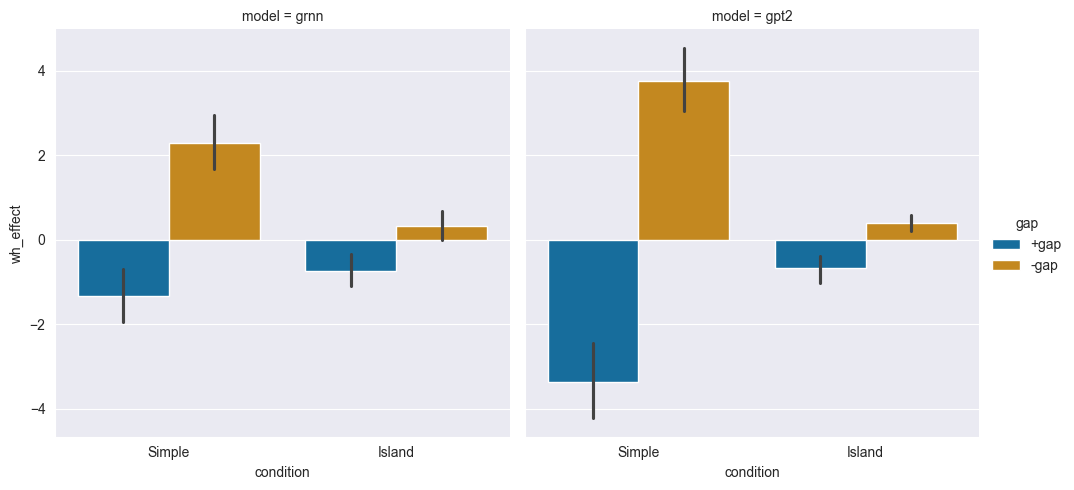

In [26]:
sns.catplot(x="condition", y="wh_effect", hue="gap", data=island_effects, kind="bar", col = "model",
            estimator="mean")
plt.savefig("figures/wilcox_cnp_island.png")

In [27]:
from analysis import * 

In [28]:
model = "gpt2"
control_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_obj_{model_name}.json", is_tuples = True)
island_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_that_{model_name}.json", is_tuples = True)

def island_surprisals(condition_name, tuples, model_name):
    stim_id = 1
    # adding surprisals individually because that's what works with the sentence tuples
    surprisals = []
    for stim_set in tuples:
        stim_set = stim_set.to_dict()
        base_info = {
            "item": stim_id,
            "model": model_name,
            "island": 1 if condition_name == "island" else 0,
        }
        surprisals.append(modify_base_dict("s_ab", stim_set, base_info))
        surprisals.append(modify_base_dict("s_xb", stim_set, base_info))
        surprisals.append(modify_base_dict("s_ax", stim_set, base_info))
        surprisals.append(modify_base_dict("s_xx", stim_set, base_info))
        stim_id +=1
    return surprisals

In [29]:
all_island_surprisals = []
for model_name in ["gpt2", "grnn"]:
    control_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_obj_{model_name}.json", is_tuples = True)
    island_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_that_{model_name}.json", is_tuples = True)
    all_island_surprisals += island_surprisals("control", control_tuples, model_name)
    all_island_surprisals += island_surprisals("island", island_tuples, model_name)

In [30]:
all_island_surprisals = pd.DataFrame(all_island_surprisals)


### Basic Filler Gap Licensing

We first run the test on the simple items

In [31]:
simple_surprisals = all_island_surprisals[all_island_surprisals['island'] == 0]

basic_formula = "surprisal ~ wh * gap + (wh+gap || item)"

summaries = []
for model_name in models:
    model_data = simple_surprisals[simple_surprisals['model'] == model_name]
    model = Lmer(basic_formula, data = model_data)
    model.fit()
    summary = model.summary()
    summary['model'] = model_name
    summaries.append(summary)
pd.concat(summaries)

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -288.815 	 AIC: 593.631

Random effects:

                 Name     Var    Std
item      (Intercept)  19.290  4.392
item.1             wh   0.000  0.000
item.2            gap  21.395  4.626
Residual                2.663  1.632

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -288.815 	 AIC: 593.631

Random effects:

                 Name     Var    Std
item      (Intercept)  19.290  4.392
item.1             wh   0.000  0.000
item.2            gap  21.395  4.626
Residual                2.663  1.632

No random effect correlations specified

Fixed 

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig,model
(Intercept),14.503,12.768,16.239,0.885,30.619,16.379,0.000,***,gpt2
wh,3.757,2.902,4.612,0.436,49.339,8.613,0.000,***,gpt2
gap,2.692,0.778,4.607,0.977,33.321,2.756,0.009,**,gpt2
wh:gap,-7.129,-8.338,-5.920,0.617,49.339,-11.558,0.000,***,gpt2
(Intercept),16.030,13.705,18.355,1.186,28.132,13.513,0.000,***,grnn
wh,2.298,1.633,2.963,0.339,52.618,6.775,0.000,***,grnn
gap,6.210,2.851,9.569,1.714,28.083,3.624,0.001,**,grnn
wh:gap,-3.621,-4.562,-2.681,0.480,52.618,-7.550,0.000,***,grnn


The three-way interaction term (filler x gap x island) is significant for both models.

In [32]:
grnn_island = all_island_surprisals[all_island_surprisals['model'] == 'grnn']
model = Lmer("surprisal~wh*gap*island+(gap||item)", data = grnn_island)
model.fit()
model.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -569.953 	 AIC: 1161.906

Random effects:

                 Name     Var    Std
item      (Intercept)  33.538  5.791
item.1            gap  64.841  8.052
Residual                3.803  1.950

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -569.953 	 AIC: 1161.906

Random effects:

                 Name     Var    Std
item      (Intercept)  33.538  5.791
item.1            gap  64.841  8.052
Residual                3.803  1.950

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),16.030,13.767,18.293,1.155,31.625,13.881,0.000,***
wh,2.298,1.276,3.319,0.521,160.061,4.409,0.000,***
gap,6.210,3.057,9.363,1.609,31.786,3.861,0.001,***
island,-2.362,-3.384,-1.341,0.521,160.061,-4.532,0.000,***
wh:gap,-3.621,-5.066,-2.177,0.737,160.061,-4.913,0.000,***
wh:island,-1.976,-3.420,-0.531,0.737,160.061,-2.680,0.008,**
gap:island,2.226,0.782,3.671,0.737,160.061,3.020,0.003,**
wh:gap:island,2.563,0.520,4.606,1.042,160.061,2.459,0.015,*


## Testing for Gap Effects

Following Kobzeva et al (2023), we separately look for filled gap effects (-gap) and unlicensed gap (+gap) effects.
They fit the regression models to filler effects and code for islands the feature, rather than fitting the model on raw surprisal effects.

In [33]:
def code_island(value):
    if value == "Island":
        return -0.5
    else:
        return 0.5

island_effects['island'] = island_effects['condition'].apply(code_island)

In [35]:
grnn_effects = island_effects[island_effects['model'] == 'grnn']
gap_effects = grnn_effects[grnn_effects['gap'] == '+gap']
nogap_effects = grnn_effects[grnn_effects['gap'] == '-gap']
formula = "wh_effect ~ island + (1 + island || item)"
model = Lmer(formula, data = gap_effects)
model.fit()
model.summary()

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by REML [’lmerMod’]
Formula: wh_effect~island+(1+island||item)

Family: gaussian	 Inference: parametric

Number of observations: 56	 Groups: {'item': 28.0}

Log-likelihood: -97.975 	 AIC: 205.950

Random effects:

                 Name    Var    Std
item      (Intercept)  0.848  0.921
item.1         island  0.944  0.971
Residual               0.959  0.979

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: wh_effect~island+(1+island||item)

Family: gaussian	 Inference: parametric

Number of observations: 56	 Groups: {'item': 28.0}

Log-likelihood: -97.975 	 AIC: 205.950

Random effects:

                 Name    Var    Std
item      (Intercept)  0.848  0.921
item.1         island  0.944  0.971
Residual               0.959  0.979

No random 

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-1.030,-1.457,-0.603,0.218,27.0,-4.730,0.000,***
island,-0.587,-1.214,0.039,0.320,27.0,-1.838,0.077,.


In [35]:
model = Lmer(formula, data = nogap_effects)
model.fit()
model.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: wh_effect~island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 56	 Groups: {'item': 28.0}

Log-likelihood: -100.982 	 AIC: 209.964

Random effects:

                 Name    Var    Std
item      (Intercept)  0.206  0.453
Residual               1.983  1.408

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: wh_effect~island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 56	 Groups: {'item': 28.0}

Log-likelihood: -100.982 	 AIC: 209.964

Random effects:

                 Name    Var    Std
item      (Intercept)  0.206  0.453
Residual               1.983  1.408

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.310,0.905,1.715,0.207,27.0,6.336,0.0,***
island,1.976,1.238,2.713,0.376,27.0,5.250,0.0,***


We now try fitting models to both the presence of fillers and islands. 

In [38]:
def code_island(value):
    if value == 1:
        return -0.5
    else:
        return 0.5

def code_filler(value):
    if value == 1:
        return 0.5
    else:
        return -0.5

def reformat_for_gap(data):
    data['island'] = data['island'].apply(code_island)
    data['filler'] = data['wh'].apply(code_filler)
    return data
island_gap_surprisals = reformat_for_gap(all_island_surprisals)

Our method: filler and island

In [39]:
grnn = island_gap_surprisals[(island_gap_surprisals['model'] == 'grnn')]
gap = grnn[grnn['gap'] == 1]
no_gap = grnn[grnn['gap'] == 0]

In [40]:
formula = "surprisal ~ filler * island + (1 | item)"
model = Lmer(formula, data = gap)
model.fit()
model.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~filler*island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -278.086 	 AIC: 568.173

Random effects:

                 Name     Var    Std
item      (Intercept)  16.822  4.101
Residual                4.453  2.110

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~filler*island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -278.086 	 AIC: 568.173

Random effects:

                 Name     Var    Std
item      (Intercept)  16.822  4.101
Residual                4.453  2.110

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),21.657,20.088,23.226,0.800,27.0,27.060,0.000,***
filler,-1.030,-1.812,-0.248,0.399,81.0,-2.582,0.012,*
island,-0.158,-0.939,0.624,0.399,81.0,-0.395,0.694,
filler:island,-0.587,-2.151,0.976,0.798,81.0,-0.737,0.464,


In [41]:
formula = "surprisal ~ filler + island +(1 | item)"
model = Lmer(formula, data = no_gap)
model.fit()
model.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~filler+island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -277.554 	 AIC: 565.108

Random effects:

                 Name     Var    Std
item      (Intercept)  34.847  5.903
Residual                3.404  1.845

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~filler+island+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 112	 Groups: {'item': 28.0}

Log-likelihood: -277.554 	 AIC: 565.108

Random effects:

                 Name     Var    Std
item      (Intercept)  34.847  5.903
Residual                3.404  1.845

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),15.504,13.291,17.717,1.129,27.0,13.731,0.0,***
filler,1.310,0.627,1.993,0.349,82.0,3.757,0.0,***
island,3.350,2.667,4.033,0.349,82.0,9.609,0.0,***
